In [7]:
#TEST OPENAQ API KEY 

#API-Key: "5639e7839da0fe184a5f50e92bc33a48cd4570469031066036957d3b155daf8c


import os
import time
import requests
import pandas as pd
from dateutil.parser import isoparse

API_KEY = os.getenv("OPENAQ_API_KEY", "5639e7839da0fe184a5f50e92bc33a48cd4570469031066036957d3b155daf8c")  # pon tu key aquí si no usas variable de entorno
print("Using API key (first 6 chars):", (API_KEY or "")[:6], "…")


r = requests.get(
    "https://api.openaq.org/v3/parameters",
    headers={"X-API-Key": API_KEY, "Accept": "application/json"},
    timeout=30,
)

print("Status code:", r.status_code)
print("Short answer:", r.text[:300])
r.raise_for_status()
print("OK: the key is working ✅")


Using API key (first 6 chars): 5639e7 …
Status code: 200
Short answer: {"meta":{"name":"openaq-api","website":"/","page":1,"limit":100,"found":46},"results":[{"id":1,"name":"pm10","units":"µg/m³","displayName":"PM10","description":"Particulate matter less than 10 micrometers in diameter mass concentration"},{"id":2,"name":"pm25","units":"µg/m³","displayName":"PM2.5","d
OK: the key is working ✅


In [14]:
#============= READ THE DATA FROM EXCEL locations and pollutants =============

import pandas as pd
import numpy as np

nyc_pollutants = pd.read_excel(r"C:\Users\elbgr\OneDrive\Escritorio\powerpuff_girls\pollutants_nyc.xlsx")
nyc_pollutants
# total no of rows= 68618
# no of columns= 8 pollutants= pm25, pm10, o3, pm1, so2, co.

print(nyc_pollutants['pm25'].isna().sum()) #12538
print(nyc_pollutants['pm10'].isna().sum()) #42884
print(nyc_pollutants['o3'].isna().sum())  #61618
print(nyc_pollutants['pm1'].isna().sum())  #37246
print(nyc_pollutants['so2'].isna().sum())  #63618
print(nyc_pollutants['co'].isna().sum())  #62618

# ============= DROP THE COLUMNS WITH THE MOST NULL VALUES =============
cols_to_consider = ["o3", "so2", "co"]  # your 3 targets
to_drop = [c for c in cols_to_consider if c in nyc_pollutants.columns and nyc_pollutants[c].isna().any()]
pollutants_avg = nyc_pollutants.drop(columns=to_drop, errors="ignore")


# See which pollutants each sensor can detect

print(pollutants_avg['location_name'].unique())
pollutants_avg=pollutants_avg.pivot_table(index=['location_name'], values=['pm25', 'pm10', 'pm1'], aggfunc=np.mean)

pollutants_avg.to_csv("pollutants_avg.csv", index=False, encoding="utf-8") 

#now i want to divided every location in boroughs
dic_boroughs = {
    "54th St & Flushing [NYC Testbed Pilot]":"Queens",
    "54th St & Grand Ave [NYC Testbed Pilot]":"Queens",
    "56th St & Flushing [NYC Testbed Pilot]":"Queens",
    "56th St & Grand Ave [NYC Testbed Pilot]":"Queens",
    "57th St/Front of School [NYC Testbed Pilot]":"Queens",
    "7th Ave and W 16th St":"Manhattan",
    "Bayside, NY":"Queens",
    "Bayside, NY 11361":"Queens",
    "Bklyn - PS 314":"Brooklyn",
    "Bklyn - PS274":"Brooklyn",
    "Bronx - IS52":"Bronx",
    "Bronx - IS74":"Bronx",
    "Caton Ave and Ocean Pkwy, Brooklyn":"Brooklyn",
    "CCNY":"Manhattan",
    "Closest to SA unit on PS9 campus":"Queens",
    "Division Street":"Manhattan",
    "E Houston St between Clinton St & Attorney St":"Manhattan",
    "Franklin Avenue":"Brooklyn",
    "Hillcrest, NY":"Queens",
    "Manhattan/IS143":"Manhattan",
    "Maspeth":"Queens",
    "Metal fence on PS9 back campus [NYC Testbed Pilot]":"Queens",
    "Morrisania":"Bronx",
    "Near Bay 50 St":"Brooklyn",
    "Port Richmond":"Staten Island",
    "PS 19":"Manhattan",
    "Queens":"Queens",
    "Queens Near-road":"Queens",
    "State Dept of Environmental Conservation":"Queens",
    "Win Son":"Brooklyn"
}

#Create a column 'borough' by mapping the index (location_name) using the dictionary

pollutants_avg['borough']= pollutants_avg.index.map(dic_boroughs)

# remove rows with NaN in borough
pollutants_avg = pollutants_avg.dropna(subset=["borough"]).copy()
# if borough is categorical and you want to clean unused categories:
if pd.api.types.is_categorical_dtype(pollutants_avg["borough"]):
    pollutants_avg["borough"] = pollutants_avg["borough"].cat.remove_unused_categories()

# divide it by boroughs and calculate the mean of each pollutant
pollutant_cols = [c for c in ["pm1","pm10","pm25"] if c in pollutants_avg.columns]

# average per borough
avg_by_borough = (pollutants_avg.groupby("borough")[pollutant_cols]
                    .mean(numeric_only=True)
                    .reset_index().round(2))


avg_by_borough

# encoding to utf-8 allows to save special characters

#avg_by_borough.to_csv("avg_by_borough.csv", index=False, encoding="utf-8") 








12538
42884
61618
37246
63618
62618
['54th St & Grand Ave [NYC Testbed Pilot]'
 '57th St/Front of School [NYC Testbed Pilot]'
 '54th St & Flushing [NYC Testbed Pilot]'
 '56th St & Flushing [NYC Testbed Pilot]'
 '56th St & Grand Ave [NYC Testbed Pilot]' '7th Ave and W 16th St'
 'Bayonne' 'Bayside, NY' 'Bayside, NY 11361' 'Bklyn - PS 314'
 'Bklyn - PS274' 'Bronx - IS52' 'Bronx - IS74' 'CCNY' 'Carteret, NJ'
 'Caton Ave and Ocean Pkwy, Brooklyn' 'Closest to SA unit on PS9 campus'
 'Division Street' 'Downtown Montclair' 'DropHome'
 'E Houston St between Clinton St & Attorney St' 'East Orange' 'Elizabeth'
 'Elizabeth Trailer' 'Fort Lee Near Road' 'Franklin Avenue'
 'Hamilton Park, Jersey City' 'Hillcrest, NY' 'Jersey City'
 'Jersey City FH' 'Jersey City Heights' 'Jersey City Newport' 'Leonia'
 'Manhattan/IS143' 'Maspeth'
 'Metal fence on PS9 back campus [NYC Testbed Pilot]' 'Montclair, NJ'
 'Morrisania' 'NJBAM Test Weehawken' 'Near Bay 50 St' 'Newark Firehouse'
 'PS 19' 'Pfizer Lab' 'Port Ri

C:\Users\elbgr\AppData\Local\Temp\ipykernel_19684\4002273478.py:27: FutureWarning: The provided callable <function mean at 0x00000248FF25E5C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pollutants_avg=pollutants_avg.pivot_table(index=['location_name'], values=['pm25', 'pm10', 'pm1'], aggfunc=np.mean)
C:\Users\elbgr\AppData\Local\Temp\ipykernel_19684\4002273478.py:72: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(pollutants_avg["borough"]):


,borough,pm1,pm10,pm25
0,Bronx,NaN,12.78,6.46
1,Brooklyn,7.07,14.88,10.32
2,Manhattan,8.98,9.62,10.15
3,Queens,4.96,8.67,8.70
4,Staten Island,NaN,NaN,5.90


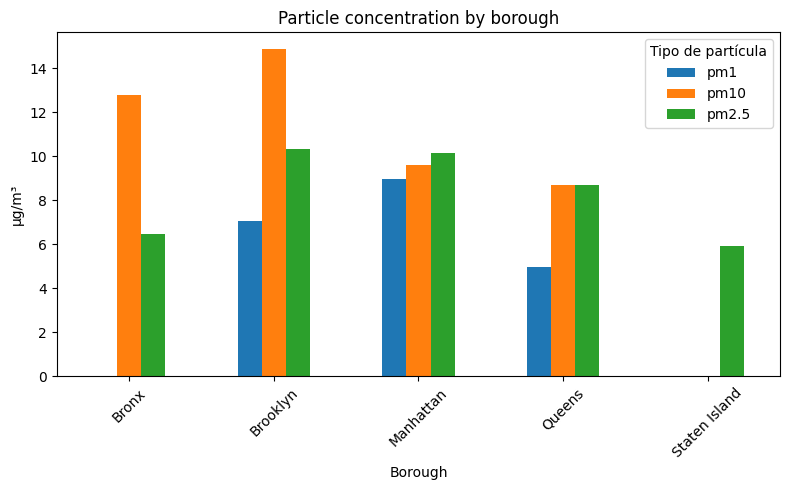

In [15]:
# =========== GRAPH ==========
import matplotlib.pyplot as plt
avg_by_borough.rename(columns={"pm25": "pm2.5"}, inplace=True)
# Crear gráfico
avg_by_borough.plot(x='borough', y=['pm1', 'pm10', 'pm2.5'], kind='bar', figsize=(8,5))
plt.title('Particle concentration by borough')
plt.xlabel('Borough')
plt.ylabel('µg/m³')
plt.legend(title='Tipo de partícula')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# =========== REACH FOR THE SENSORS THAT CAN DETECT THE 3 TARGET POLLUTANTS ===========
# Create a list of the pollutants I want to detect
required = ["pm1", "pm10", "pm25"]

# The we use MASK: the output is True if that location doesn't have any null value
mask_all = pollutants_avg[required].notna().all(axis=1)

all_pollutants = pollutants_avg.loc[mask_all].copy()

all_pollutants = pollutants_avg.loc[mask_all, ["pm1", "pm10", "pm25"]].copy()

all_pollutants = all_pollutants.reset_index()

all_pollutants

# Very few sensors can detect all the 3 pollutants so we decide to work with every sensor even if they don't detect all the pollutants
# we will measure the risk by the danger of the pollutant that is detected.




,location_name,pm1,pm10,pm25
0,7th Ave and W 16th St,5.959778,9.617276,8.845183
1,"Bayside, NY",4.366577,8.279422,10.784854
2,"Hillcrest, NY",5.581091,9.300645,6.930326
3,Near Bay 50 St,4.803324,8.194429,4.119288
4,State Dept of Environmental Conservation,4.723867,8.421382,8.474114
5,Win Son,13.625600,21.568065,20.309700


In [10]:
#green areas

import pandas as pd
import numpy as np


df = pd.read_csv(r"C:\Users\elbgr\Downloads\2015-street-tree-census-tree-data.csv.zip")
print(df["borough"].unique())
print(df["borough"].isna().sum()) #0
# Create a df with only alive trees in NY:
df_alive = df[(df["status"] == "Alive")]
df_alive.head()

#Create a series with the number of trees per borough

tree_ny = df["borough"].value_counts()

tree_ny










['Queens' 'Brooklyn' 'Manhattan' 'Staten Island' 'Bronx']
0


borough
Queens           250551
Brooklyn         177293
Staten Island    105318
Bronx             85203
Manhattan         65423
Name: count, dtype: int64

In [ ]:
#============= MERGUED DATAFRAMES POLLUTANTS AND TREES =============
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

merged_score = pd.merge(avg_by_borough, tree_ny, left_on="borough", right_index=True)
merged_score.rename(columns={"count":"number_of_trees"})

# scaler normalizes the data setting a Min-Max (0–1) 
scaler = MinMaxScaler()

# We'll normalize each column separately, making sure that "more trees" = better,
# but "more pollutants" = worse.
merged_score["pm1_score"] = 1 - scaler.fit_transform(merged_score[["pm1"]])
merged_score["pm25_score"]= 1 - scaler.fit_transform(merged_score[["pm25"]])
merged_score["pm10_score"] = 1 - scaler.fit_transform(merged_score[["pm10"]])
merged_score["number_of_trees_score"] = scaler.fit_transform(merged_score[["number_of_trees"]])

# Compute the Environmental Quality Score (EQS) 
# Weights can be adjusted — here: pm1 0.35, pm25 0.25 , pm10 0.15, number_of_trees 0.25
merged_score["EQS"] = 100 * (
    0.35 * merged_score["pm1"] +
    0.25* merged_score["pm25"] +
    0.15* merged_score["pm10"] +
    0.25* merged_score["number_of_trees"] 

)





,borough,pm1,pm10,pm25,number_of_trees
0,Bronx,NaN,12.78,6.46,85203
1,Brooklyn,7.07,14.88,10.32,177293
2,Manhattan,8.98,9.62,10.15,65423
3,Queens,4.96,8.67,8.70,250551
4,Staten Island,NaN,NaN,5.90,105318
